# Example Simulations, version 2

## Load packages.

In [1]:
require(data.table)
require(deSolve)
require(magrittr)

require(ggplot2)


Loading required package: data.table
Loading required package: deSolve
Loading required package: magrittr
Loading required package: ggplot2


## Function to generate simulations.

In [2]:
# Create a multivariate function with specified properties:
#   tmax: maximum time
#   multiplicities: number of correlations each parameter has
#   degrees: polynomial degree of each parameter
#   dimension: the dimension of the output
#   returns a multivariate function of the vector of parameters and time
makeGenerator <- function(multiplicities, degrees, dimension) {

    single <- function(degree) {
      x0 <- runif(1)
      z0 <- runif(1)
      function(x) {
          if (x < x0)
              0
          else
              z0 * (x - x0)^degree
      }
    }
  
    locations <- lapply(multiplicities, function(m) sample(1:dimension, m))
    functions <- lapply(degrees, single)
    
    start <- runif(dimension, -0.25, 0.75)
    coefs <- matrix(runif(dimension^2, -0.25, 0.75), dimension, dimension)    
    shift <- matrix(runif(dimension^2, -0.25, 0.75), dimension, dimension)
    
    function(x, ts) {
        z <- rep(0, dimension)
        for (i in 1:length(locations))
            for (j in locations[[i]])
                z[j] <- z[j] + functions[[i]](x[i])
        ode(start, ts, function(t, y, params) {list((coefs %*% y) * z * (1 - ((shift %*% y) * z)))})
    }
    
}


## Function to run cases.

In [3]:
runCases <- function(f, xs, ts) {
    result <- NULL
    for (i in 1:nrow(xs))
        result <- rbind(
            result,
            data.table(
                case=xs[i, case],
                f(as.numeric(xs[i, .(x1, x2, x3)]), ts)
            )
        )
    result[, .(
        case,
        t=time,
        y1=`1`,
        y2=`2`,
        y3=`3`
    )]
}

## Reproducible random numbers.

In [4]:
RNGkind("Mersenne-Twister", "Inversion", "Rejection")

In [5]:
set.seed(46)

## Create a simulation function.

In [6]:
f <- makeGenerator(c(2, 2, 3), c(0, 1, 2), 3)

## Evaluate at some times.

In [7]:
ts <- seq(0, 10, 0.5)

## Create a full factorial design for eleven levels of the three input variables over the domain `[0,1]^3`.

In [8]:
xs <- data.table(
        cbind(
        case=1:11^3,
        expand.grid(
            x1=seq(0, 1, 0.1),
            x2=seq(0, 1, 0.1),
            x3=seq(0, 1, 0.1)
        )
    )
)
xs %>% dim

[1] 1331    4

In [9]:
xs %>% summary

      case              x1            x2            x3     
 Min.   :   1.0   Min.   :0.0   Min.   :0.0   Min.   :0.0  
 1st Qu.: 333.5   1st Qu.:0.2   1st Qu.:0.2   1st Qu.:0.2  
 Median : 666.0   Median :0.5   Median :0.5   Median :0.5  
 Mean   : 666.0   Mean   :0.5   Mean   :0.5   Mean   :0.5  
 3rd Qu.: 998.5   3rd Qu.:0.8   3rd Qu.:0.8   3rd Qu.:0.8  
 Max.   :1331.0   Max.   :1.0   Max.   :1.0   Max.   :1.0  

## Run all of the cases.

In [10]:
ys <- runCases(f, xs, ts)
ys %>% dim

[1] 27951     5

In [11]:
ys %>% summary

      case            t              y1                 y2        
 Min.   :   1   Min.   : 0.0   Min.   :-0.19003   Min.   :0.5145  
 1st Qu.: 333   1st Qu.: 2.5   1st Qu.:-0.18102   1st Qu.:0.5633  
 Median : 666   Median : 5.0   Median :-0.07329   Median :0.9789  
 Mean   : 666   Mean   : 5.0   Mean   : 0.45295   Mean   :1.7990  
 3rd Qu.: 999   3rd Qu.: 7.5   3rd Qu.: 0.47190   3rd Qu.:2.2340  
 Max.   :1331   Max.   :10.0   Max.   : 5.25551   Max.   :8.2071  
       y3          
 Min.   :-1.80658  
 1st Qu.: 0.09708  
 Median : 0.33970  
 Mean   : 0.23427  
 3rd Qu.: 0.40936  
 Max.   : 2.25402  

## Plot the results.

### `y[1](t)`

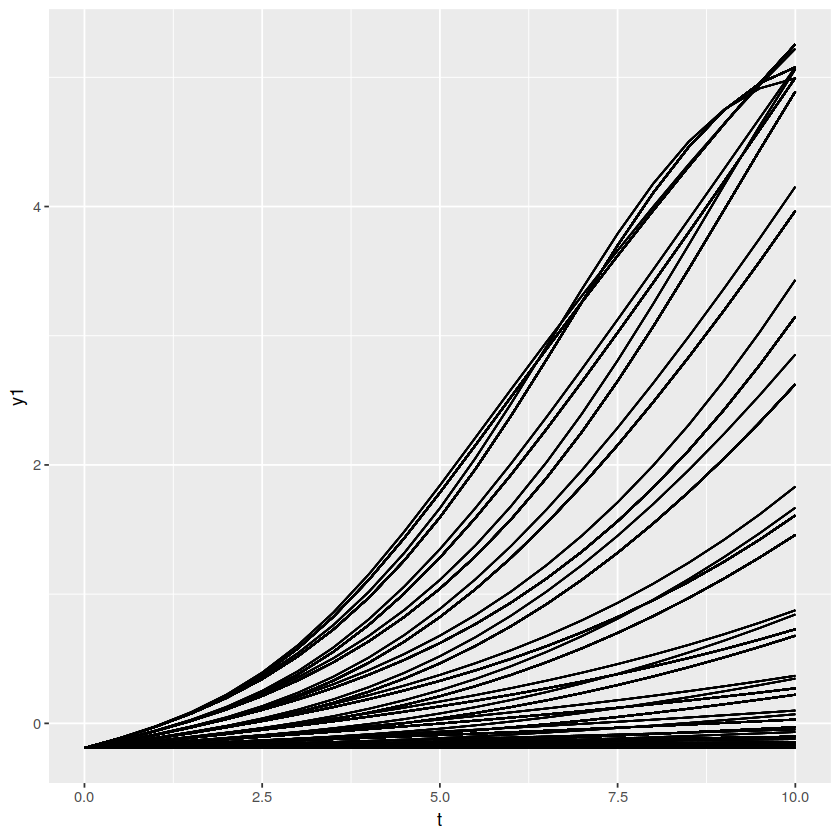

In [12]:
ggplot(ys, aes(x=t, y=y1, group=case)) + geom_line()

### `y[2](t)`

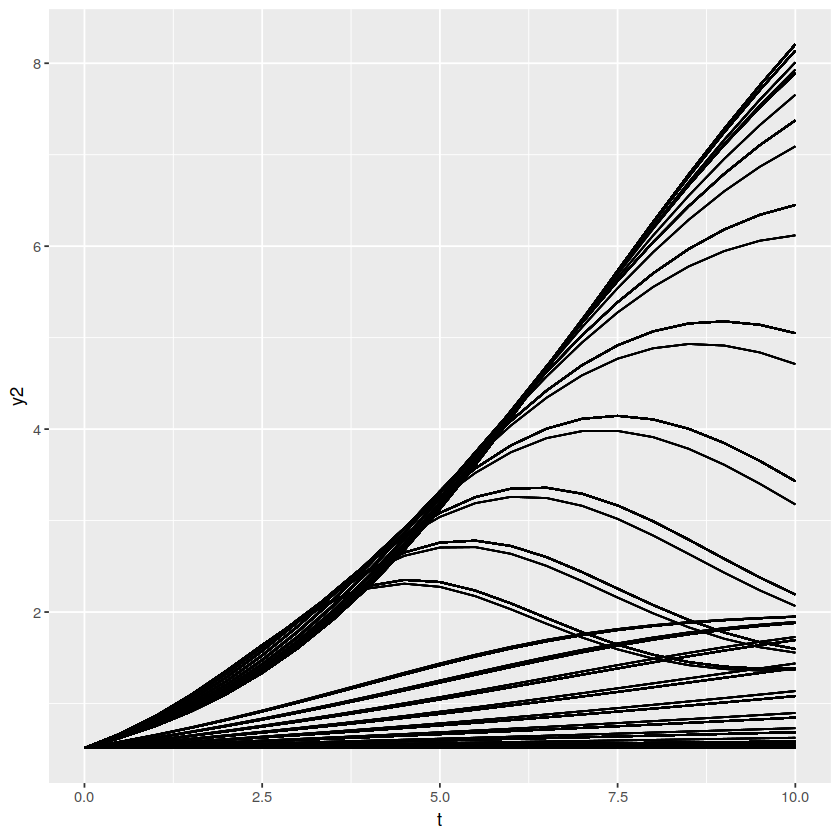

In [13]:
ggplot(ys, aes(x=t, y=y2, group=case)) + geom_line()

### `y[3](t)`

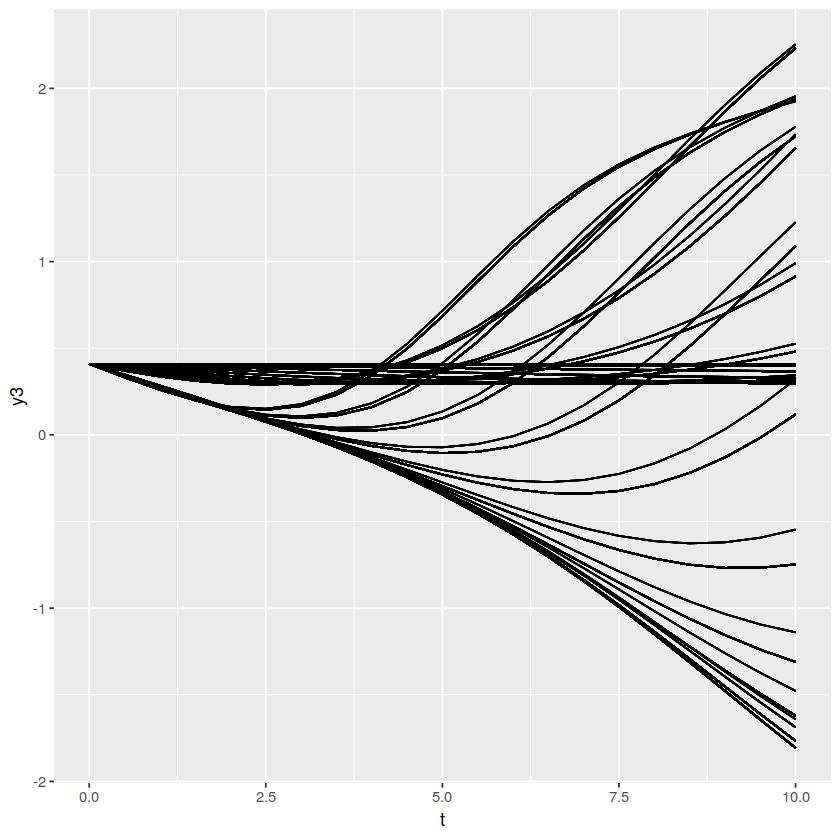

In [14]:
ggplot(ys, aes(x=t, y=y3, group=case)) + geom_line()

## Store the results.

In [15]:
write.csv(xs, file="xs-3d-20200322a.csv", row.names=FALSE)
write.csv(ys, file="ys-3d-20200322a.csv", row.names=FALSE)

## Two-dimensional subset.

If we want a simpler dataset, one with two input dimensions and two output dimensions, we can simply fix one of the input variables and discard one of the output variables.

### Fix `x3` at `0.8` and discard `y3`.

In [16]:
xs2d <- xs[x3 == 0.8, .(case, x1, x2)]
xs2d %>% dim

[1] 121   3

In [17]:
ys2d <- merge(xs2d, ys, on=case)[, .(case, t, y1, y2)]

In [18]:
ys2d %>% dim

[1] 2541    4

### Plot results.

#### `y[1](t)`

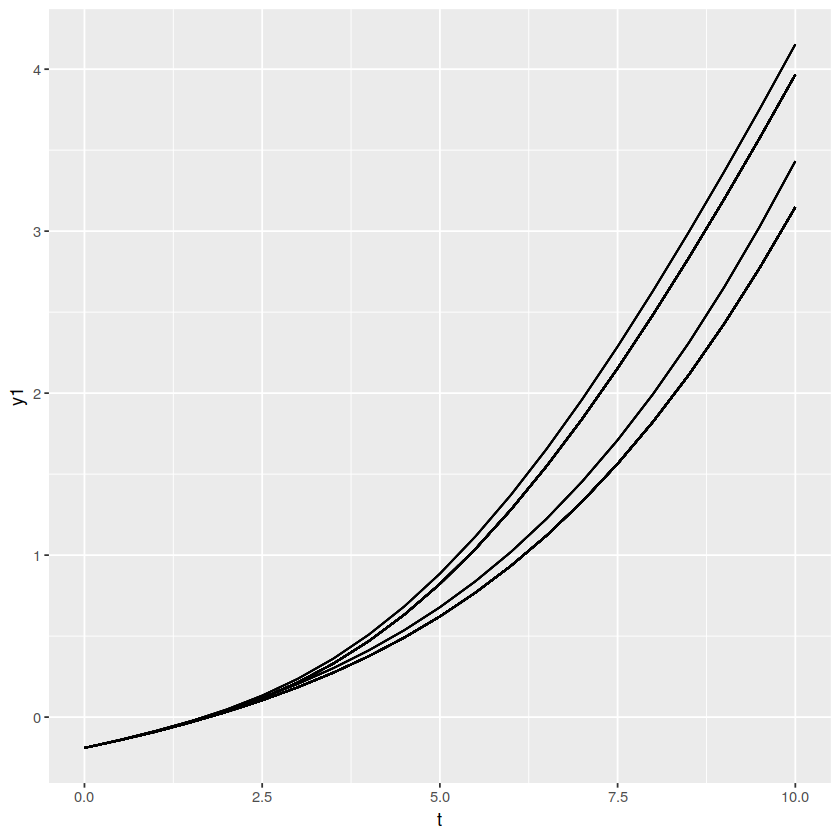

In [19]:
ggplot(ys2d, aes(x=t, y=y1, group=case)) + geom_line()

#### `y[2](t)`

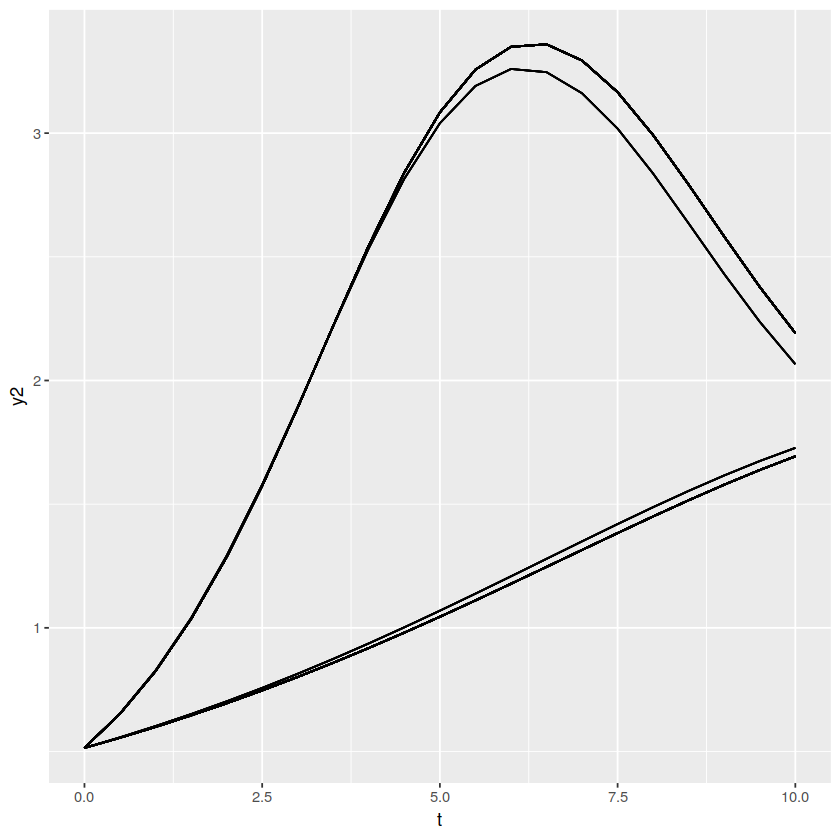

In [20]:
ggplot(ys2d, aes(x=t, y=y2, group=case)) + geom_line()

### Store the results.

In [21]:
write.csv(xs2d, file="xs-2d-20200322a.csv", row.names=FALSE)
write.csv(ys2d, file="ys-2d-20200322a.csv", row.names=FALSE)